In [7]:
# Import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

In [2]:
# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test)= cifar10.load_data()

In [3]:
# Reshape the image data from (num_samples, height, width, channels) to (num_samples, features)
X_train = X_train.reshape(50000, 3*32*32) # Reshape training images to flatten the 3x32x32 arrays into vectors of length 3072
X_test = X_test.reshape(10000, 3*32*32) # Reshape test images similarly

# Flatten the label arrays from (num_samples, 1) to (num_samples,)
y_train = y_train.flatten() # Flatten training labels to a 1D array
y_test = y_test.flatten() # Flatten testing labels

# Create boolean index arrays for each class in the TRAINING set
airplane_index = (y_train == 0)  # Index of airplane images in the training set
automobile_index = (y_train == 1)  # Index of automobile images in the training set
bird_index = (y_train == 2) # Index of bird images in the training set
cat_index = (y_train == 3) # and so on ...
deer_index = (y_train == 4)
dog_index = (y_train == 5)
frog_index = (y_train == 6)
horse_index = (y_train == 7)
ship_index = (y_train == 8)
truck_index = (y_train == 9)

# Create boolean index arrays for each class in the TEST set (overwrites training set indices)
airplane_index = (y_test == 0)  # Index of airplane images in the test set
automobile_index = (y_test == 1)  # Index of automobile images in the test set
bird_index = (y_test == 2)  # Index of bird images in the test set
cat_index = (y_test == 3)  # and so on ...
deer_index = (y_test == 4)  
dog_index = (y_test == 5)
frog_index = (y_test == 6)
horse_index = (y_test == 7)
ship_index = (y_test == 8)
truck_index = (y_test == 9)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42) # Initialize a RandomForestClassifier with a fixed random state for reproducibility

param_grid = { # Define the parameter grid for the grid search
    'n_estimators': [50, 100, 200, 500, 1000], # Number of trees in the forest
    'criterion': ['gini', 'entropy'], # Function to measure the quality of a split
    'max_depth': [3, 10, 20, 50, 100, None], # Maximum depth of the tree (None means no maximum depth)
    'min_samples_leaf': [1, 2, 4, 6, 10, 20],  # Minimum number of samples required to be at a leaf node
    'max_features': ["sqrt", "log2", None], # Number of features to consider when looking for the best split
    'bootstrap': [True, False] # Whether bootstrap samples are used when building trees
}

In [ ]:
# Grid Search for RandomForestClassifier for hyperparamer tuning

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

KeyboardInterrupt: 

In [ ]:
# Random Search for RandomForestClassifier for hyperparamer tuning

random_search = RandomizedSearchCV(
    estimator=rf, param_grid=param_grid, cv=5, random_state=42, n_jobs=-1
)

random_search.fit(X_train, y_train)
print("Best Bayes Search Hyperparameters:", random_search.best_params_)

In [ ]:
# Bay Search for RandomForestClassifier for hyperparamer tuning

bayes_search = BayesSearchCV(
    estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, random_state=42
)

bayes_search.fit(X_train, y_train)
print("Best Bayes Search Hyperparameters:", bayes_search.best_params_)

In [ ]:
# Initializes a RandomForestClassifier with the best hyperparameters found (e.g., through grid search or other optimization methods).
rf = RandomForestClassifier(criterion='gini', max_depth=10, max_features='sqrt', min_samples_leaf=10)

# Trains the model on the training data.
rf.fit(X_train, y_train)

# Predicts labels for the test data using the trained model.
pred = rf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt
from sklearn.multiclass import OneVsRestClassifier

# Uses OneVsRestClassifier to handle multi-class classification using a RandomForestClassifier.
# Creates a OneVsRestClassifier with the optimized RandomForestClassifier as the base estimator. This strategy creates one classifier per class, fitting each on one class vs. the rest.
rf_one_rest = OneVsRestClassifier(RandomForestClassifier(criterion='gini', max_depth=10, max_features='sqrt', min_samples_leaf=10)) 

# Trains the OneVsRestClassifier on the training data.
rf_one_rest.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=10,
                                                     min_samples_leaf=10))

In [ ]:
from sklearn.metrics import roc_curve, auc

# Gets predicted probabilities for each class on the test data.  This is needed for generating ROC curves in multi-class scenarios.  `predict_proba` returns an array of shape (n_samples, n_classes), where each element represents the probability of a sample belonging to a specific class.
y_score = rf_one_rest.predict_proba(X_test)


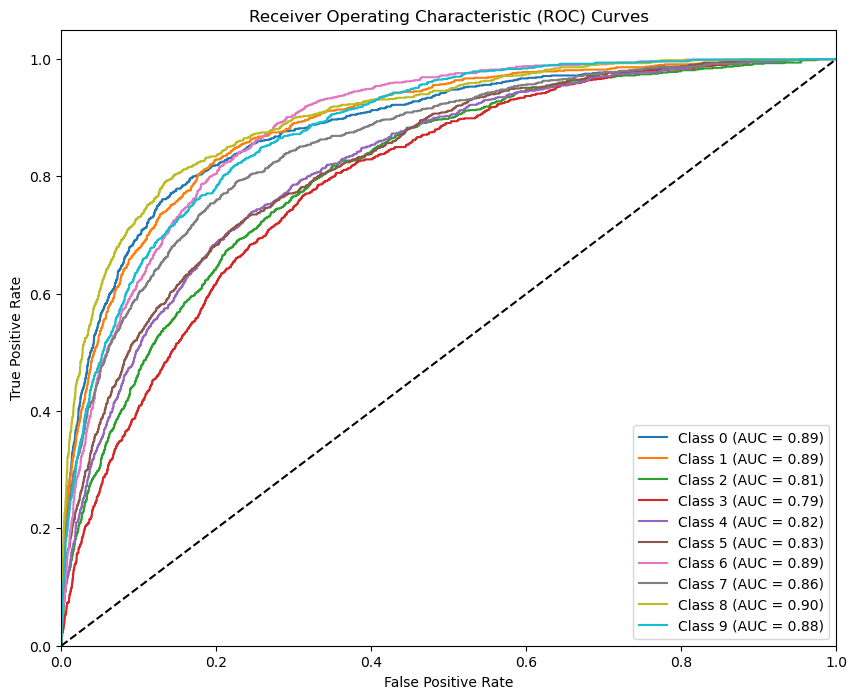

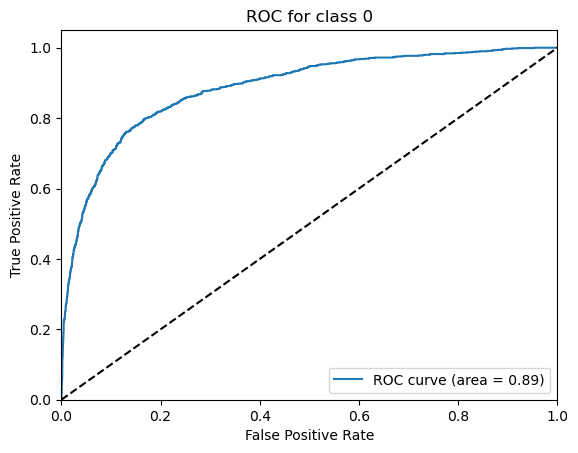

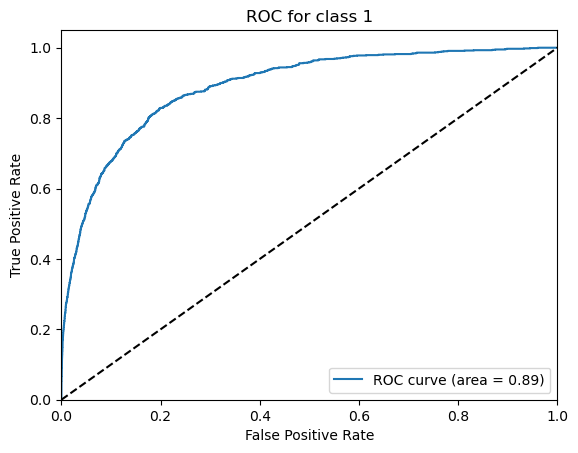

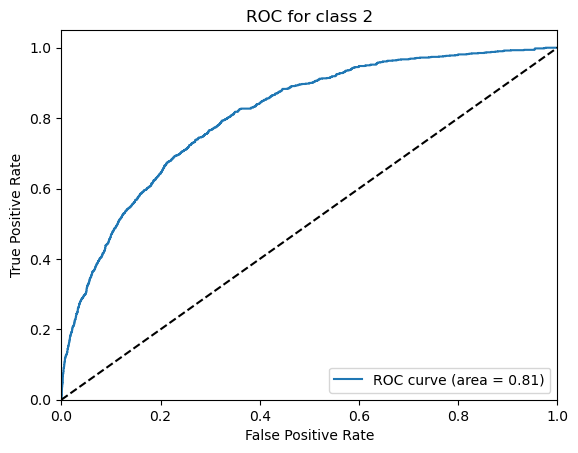

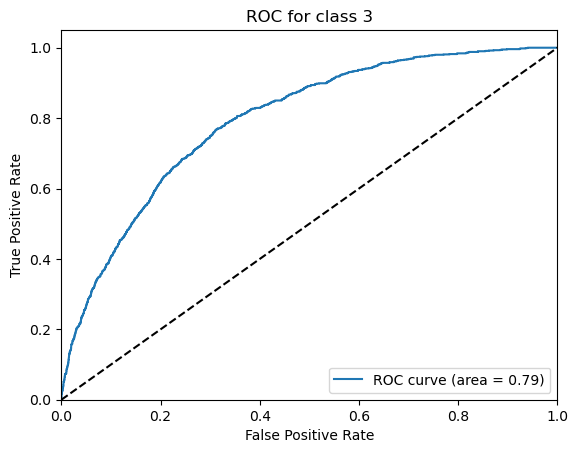

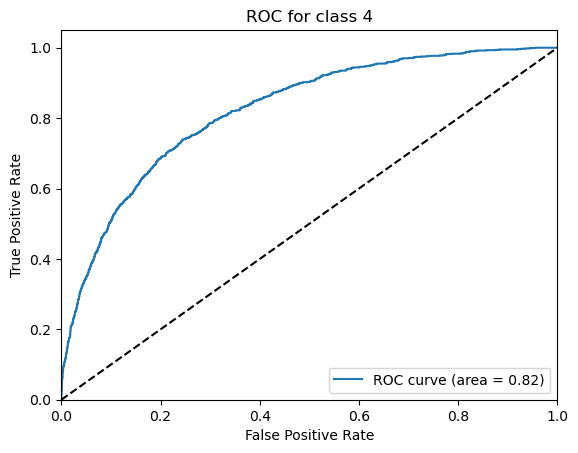

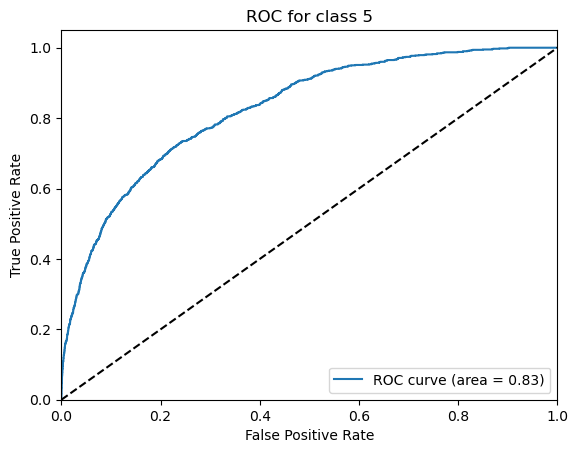

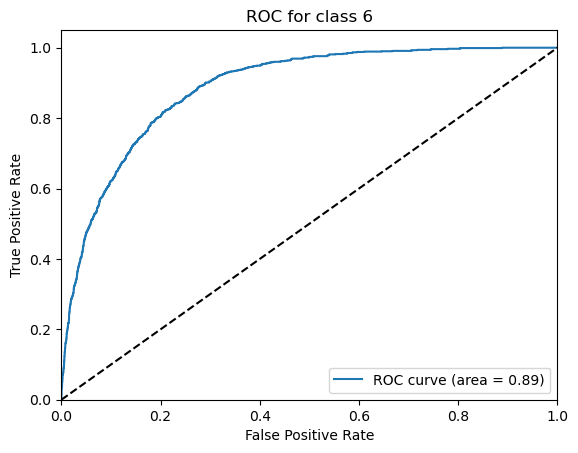

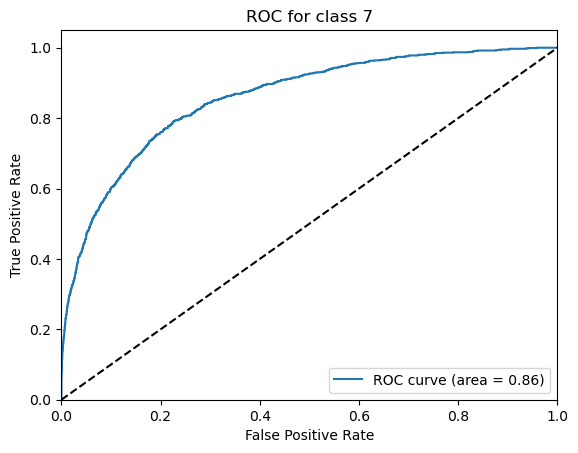

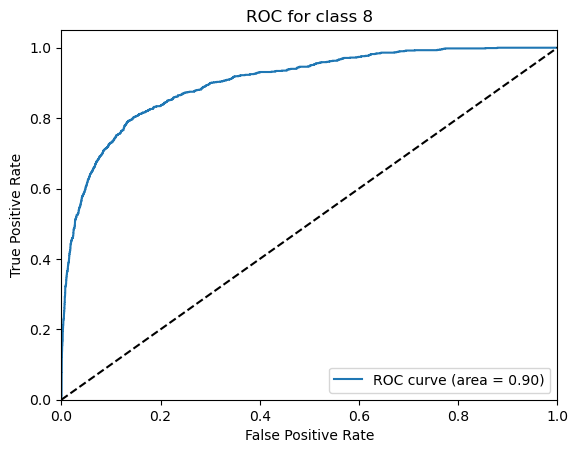

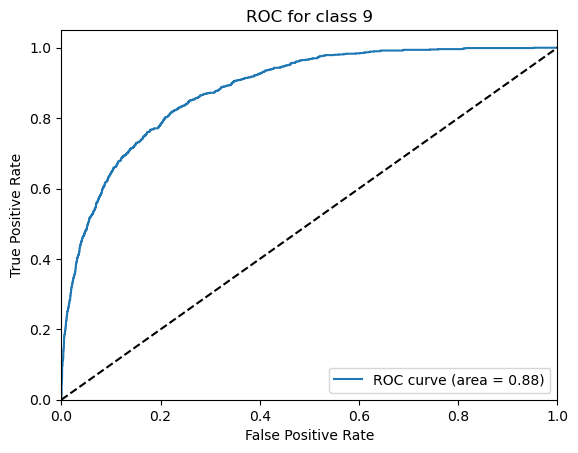

In [ ]:
# Create arrays to hold the false positive rates, true positive rates, and AUC scores
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(10):  # Assuming you have 10 classes in CIFAR-10
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for each class
for i in range(10):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for class {i}')
    plt.legend(loc="lower right")
    plt.show()

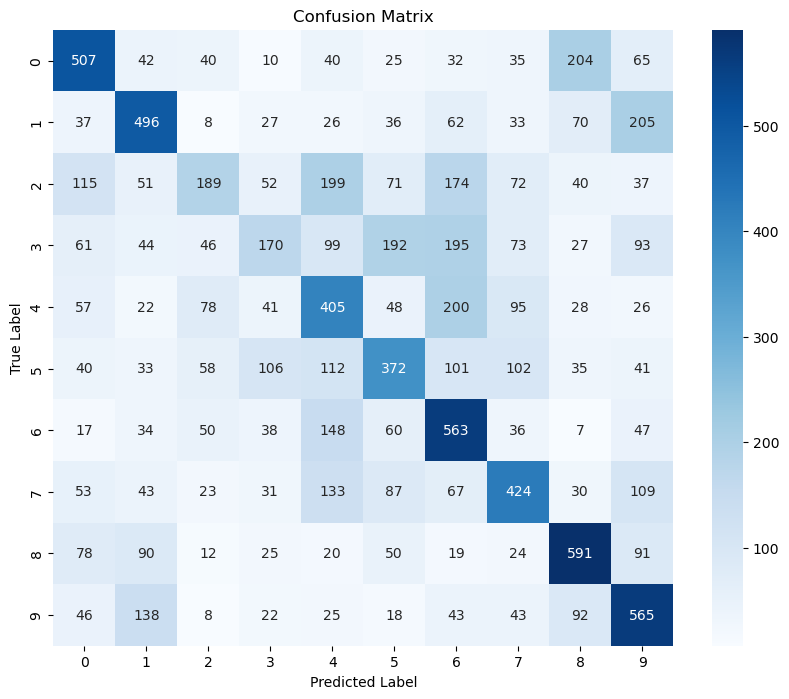

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()